# 55 Extracting Well Tops from PyVista Meshes

The following notebook illustrates how to extract well tops or in the case of GemPy well bases from PyVista meshes of GemPy models. In particular, a ray tracing algorithm in PyVista is used to extract the intersections of a borehole (PyVista Polydata) with a PyVista mesh. Straight boreholes as well as deviated boreholes can be used. 

<img src="../images/tutorial54_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg
import geopandas as gpd
import rasterio
import gempy as gp
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
file_path ='data/55_extracting_well_tops_from_pyvista_meshes/'
gg.download_gemgis_data.download_tutorial_data(filename="55_extracting_well_tops_from_pyvista_meshes.zip", dirpath=file_path)

## Creating GemPy Model

### Loading Topography

In [3]:
topo_raster = rasterio.open(file_path + 'raster1.tif')

### Creating Interfaces

In [4]:
interfaces = gpd.read_file(file_path + 'interfaces1_lines.shp')
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords.head()

,formation,geometry,X,Y,Z
0,Sand1,POINT (0.256 264.862),0.26,264.86,353.97
1,Sand1,POINT (10.593 276.734),10.59,276.73,359.04
2,Sand1,POINT (17.135 289.090),17.13,289.09,364.28
3,Sand1,POINT (19.150 293.313),19.15,293.31,364.99
4,Sand1,POINT (27.795 310.572),27.80,310.57,372.81


### Creating Orientations

In [5]:
orientations = gpd.read_file(file_path + 'orientations1.shp')
orientations = gg.vector.extract_xyz(gdf=orientations, dem=topo_raster)
orientations['polarity'] = 1
orientations

,formation,dip,azimuth,geometry,X,Y,Z,polarity
0,Ton,30.50,180.00,POINT (96.471 451.564),96.47,451.56,440.59,1
1,Ton,30.50,180.00,POINT (172.761 661.877),172.76,661.88,556.38,1
2,Ton,30.50,180.00,POINT (383.074 957.758),383.07,957.76,729.02,1
3,Ton,30.50,180.00,POINT (592.356 722.702),592.36,722.70,601.55,1
4,Ton,30.50,180.00,POINT (766.586 348.469),766.59,348.47,378.63,1
5,Ton,30.50,180.00,POINT (843.907 167.023),843.91,167.02,282.61,1
6,Ton,30.50,180.00,POINT (941.846 428.883),941.85,428.88,423.45,1
7,Ton,30.50,180.00,POINT (22.142 299.553),22.14,299.55,368.05,1


### Calculating GemPy Model

In [6]:
geo_model = gp.create_model('Model1')
gp.init_data(geo_model, [0, 972, 0, 1069, 300, 800], [50, 50, 50],
             surface_points_df=interfaces_coords,
             orientations_df=orientations,
             default_values=True)
gp.map_stack_to_surfaces(geo_model,
                         {'Strata': ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')
geo_model.set_topography(source='gdal', filepath=file_path + 'raster1.tif')
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )
sol = gp.compute_model(geo_model, compute_mesh=True)

Active grids: ['regular']
Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range             1528.9
$C_o$           55655.83
drift equations      [3]


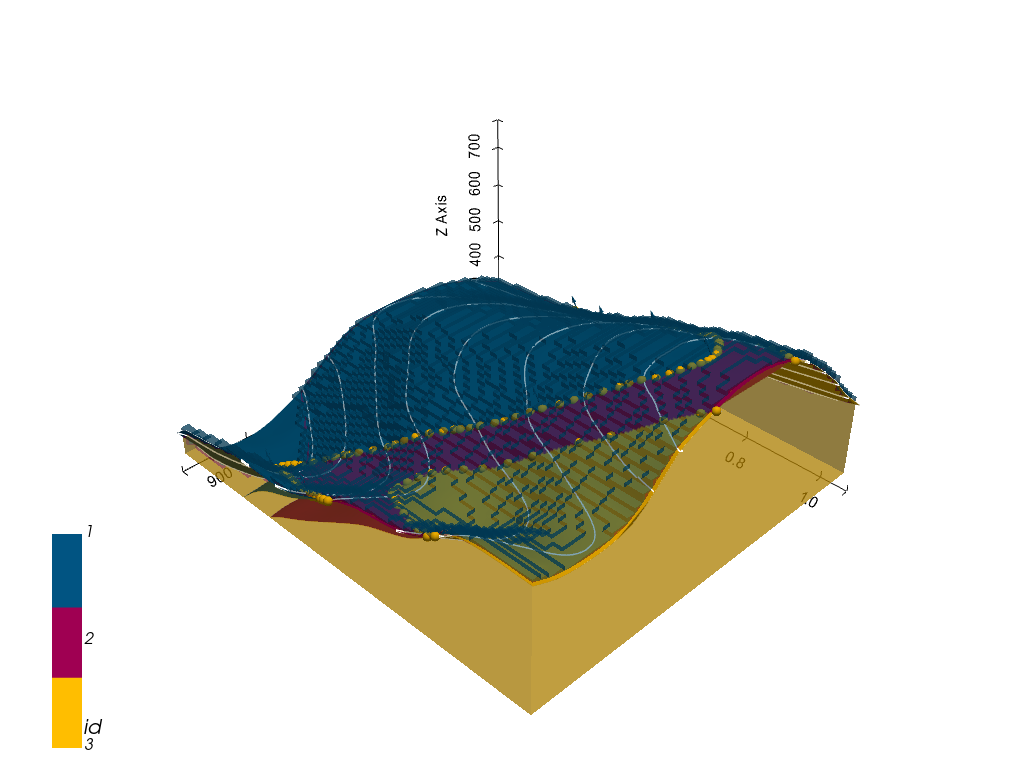

In [7]:
gpv = gp.plot_3d(geo_model, 
                 image=False, 
                 show_topography=True,
                 plotter_type='basic', 
                 notebook=True, 
                 show_lith=True,
                 show_boundaries=True)

## Extracting Surfaces from the GemPy Model

In [8]:
mesh = gg.visualization.create_depth_maps_from_gempy(geo_model=geo_model, surfaces=['Sand1', 'Ton'])
mesh

{'Sand1': [PolyData (0x1e4a0b2b3a0)
    N Cells:	4209
    N Points:	2325
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	1.672e+02, 9.497e+02
    Z Bounds:	3.050e+02, 7.250e+02
    N Arrays:	1,
  '#015482'],
 'Ton': [PolyData (0x1e49c0c30a0)
    N Cells:	5396
    N Points:	2891
    X Bounds:	9.720e+00, 9.623e+02
    Y Bounds:	2.799e+02, 1.058e+03
    Z Bounds:	3.050e+02, 7.297e+02
    N Arrays:	1,
  '#9f0052']}

## Extracting intersections between boreholes and meshes

First, a PolyData set is created and visualized. The first attempt shows a straight vertical well. 

In [9]:
well = pv.Line((500,500, 800), (500, 500, 300))
well_tube = well.tube(radius=10)
well_tube

PolyData (0x1e49cb57580)
  N Cells:	22
  N Points:	80
  X Bounds:	4.900e+02, 5.100e+02
  Y Bounds:	4.900e+02, 5.100e+02
  Z Bounds:	3.000e+02, 8.000e+02
  N Arrays:	3

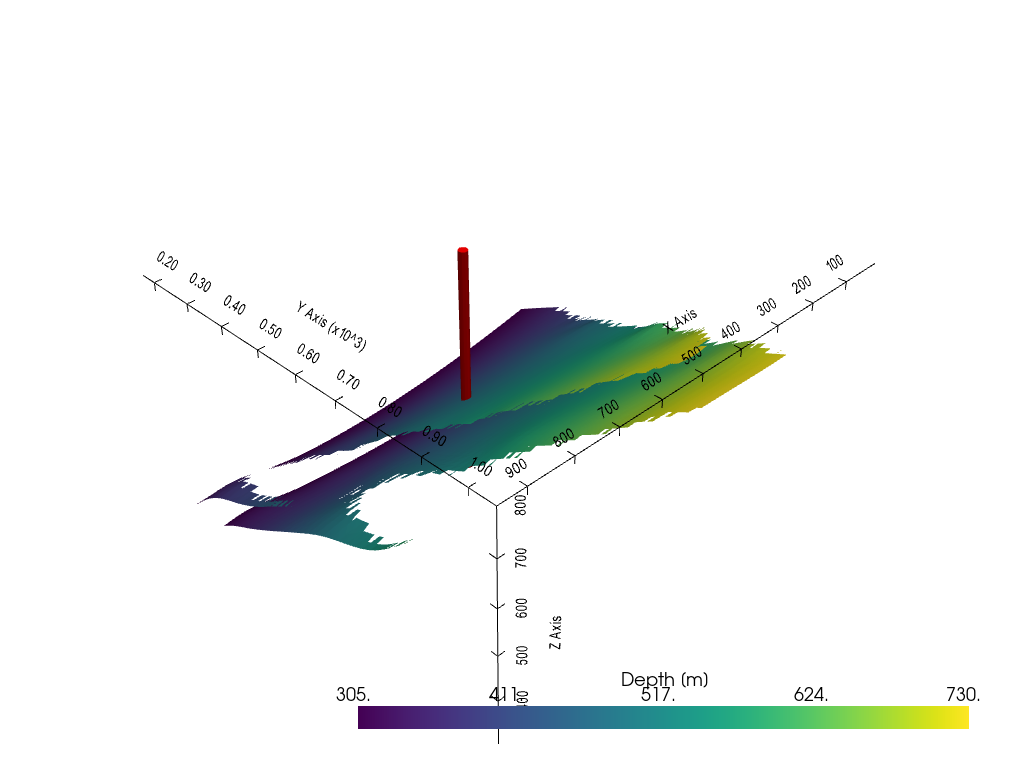

In [10]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh['Sand1'][0], scalars = 'Depth [m]')
p.add_mesh(mesh['Ton'][0], scalars = 'Depth [m]')
p.add_mesh(well_tube, color='red')
p.show_bounds()
p.show()

In [11]:
from typing import Union
def ray_trace_one_surface(surface: pv.core.pointset.PolyData,
                          origin: Union[np.ndarray, list],
                          end_point: Union[np.ndarray, list],
                          first_point: bool = False) -> tuple:
    """Function to return the depth of one surface in one well using PyVista ray tracing

    Parameters:
    ___________

        surface: pv.core.pointset.PolyData
            Calculated GemPy surface

        origin:
            Coordinates of the top of the well

        end_point:
            Coordinates of the bottom of the well

        first_point: bool
            Returns intersection of first point only

    """

    # Extracting the intersection between a PolyData set and a mesh
    intersection_points, intersection_cells = surface.ray_trace(origin=origin,
                                                                end_point=end_point,
                                                                first_point=first_point)

    return intersection_points, intersection_cells

def ray_trace_multiple_surfaces(surfaces: list,
                                borehole_top: Union[np.ndarray, list],
                                borehole_bottom: Union[np.ndarray, list],
                                first_point: bool = False) -> list:
    """Function to return the depth of multiple surfaces in one well using PyVista ray tracing

    Parameters:
    ___________

        surfaces: list
            List of calculated GemPy surfaces

        borehole_top:
            Coordinates of the top of the well

        borehole_bottom:
            Coordinates of the bottom of the well

        first_point: bool
            Returns intersection of first point only


    """

    # Extracting multiple intersections from meshes
    intersections = [ray_trace_one_surface(surface=surface,
                                           origin=borehole_top,
                                           end_point=borehole_bottom,
                                           first_point=first_point) for surface in surfaces]

    return intersections

def polyline_from_points(points):
    poly = pv.PolyData()
    poly.points = points
    the_cell = np.arange(0, len(points), dtype=np.int_)
    the_cell = np.insert(the_cell, 0, len(points))
    poly.lines = the_cell
    poly["scalars"] = np.arange(poly.n_points)
    return poly

def create_virtual_profile(names_surfaces: list,
                           surfaces: list,
                           borehole: pv.core.pointset.PolyData,
                           first_point: bool = False):
    """ Function to filter and sort the resulting well tops

    Parameters:
    ___________

        names_surfaces: list
            List of the names of the calculated GemPy surfaces

        surfaces: list
            List of calculated GemPy surfaces

        borehole_top:
            Coordinates of the top of the well

        borehole_bottom:
            Coordinates of the bottom of the well

        first_point: bool
            Returns intersection of first point only

    """

    # Creating well segments
    well_segments = [pv.Line(borehole.points[i], borehole.points[i+1]) for i in range(len(borehole.points)-1) ]

    # Extracting well tops
    well_tops = [ray_trace_multiple_surfaces(surfaces=surfaces,
                                            borehole_top=segment.points[0],
                                            borehole_bottom=segment.points[1],
                                            first_point=first_point) for segment in well_segments]
    
    # Flatten list
    well_tops = [item for sublist in well_tops for item in sublist]

    # Filtering empty lists
    well_tops_filtered = []
    list_surfaces = names_surfaces * len(well_segments)
    list_surfaces_filtered = []

    for i in range(len(well_tops)):
        if len(well_tops[i][0] != 0):
            well_tops_filtered.append(well_tops[i])
            list_surfaces_filtered.append(list_surfaces[i])
        
    z_values = [values[0][0][2] for values in well_tops_filtered]
    
    # Creating DataFrame
    df = pd.DataFrame(list(zip(list_surfaces_filtered, z_values)), columns=['Surface', 'Z'])
   
    return df


In [12]:
ray_trace_one_surface(mesh['Sand1'][0], 
                      well.points[0],
                      well.points[1])

(array([[500.     , 500.     , 465.47574]], dtype=float32), array([2895]))

In [13]:
ray_trace_multiple_surfaces([mesh['Sand1'][0], mesh['Ton'][0]], 
                              well.points[0],
                              well.points[1])

[(array([[500.     , 500.     , 465.47574]], dtype=float32), array([2895])),
 (array([[500.     , 500.     , 408.50534]], dtype=float32), array([3181]))]

In [14]:
create_virtual_profile(names_surfaces=list(mesh.keys()),
                       surfaces=[mesh['Sand1'][0], mesh['Ton'][0]],
                       borehole=well)

,Surface,Z
0,Sand1,465.48
1,Ton,408.51


The second test will be made with a not so much realistic well path but to illustrate that also deviated boreholes work to extract the intersections. Here, we define a well with three segments (four points).

In [15]:
points = np.array(((500,600, 800), 
                   (500, 550, 460), 
                   (500, 350, 300),
                   (500, 250, 500)))

polyline = polyline_from_points(points)
tube = polyline.tube(radius=15)
polyline

PolyData (0x1e49c92c340)
  N Cells:	1
  N Points:	4
  X Bounds:	5.000e+02, 5.000e+02
  Y Bounds:	2.500e+02, 6.000e+02
  Z Bounds:	3.000e+02, 8.000e+02
  N Arrays:	1

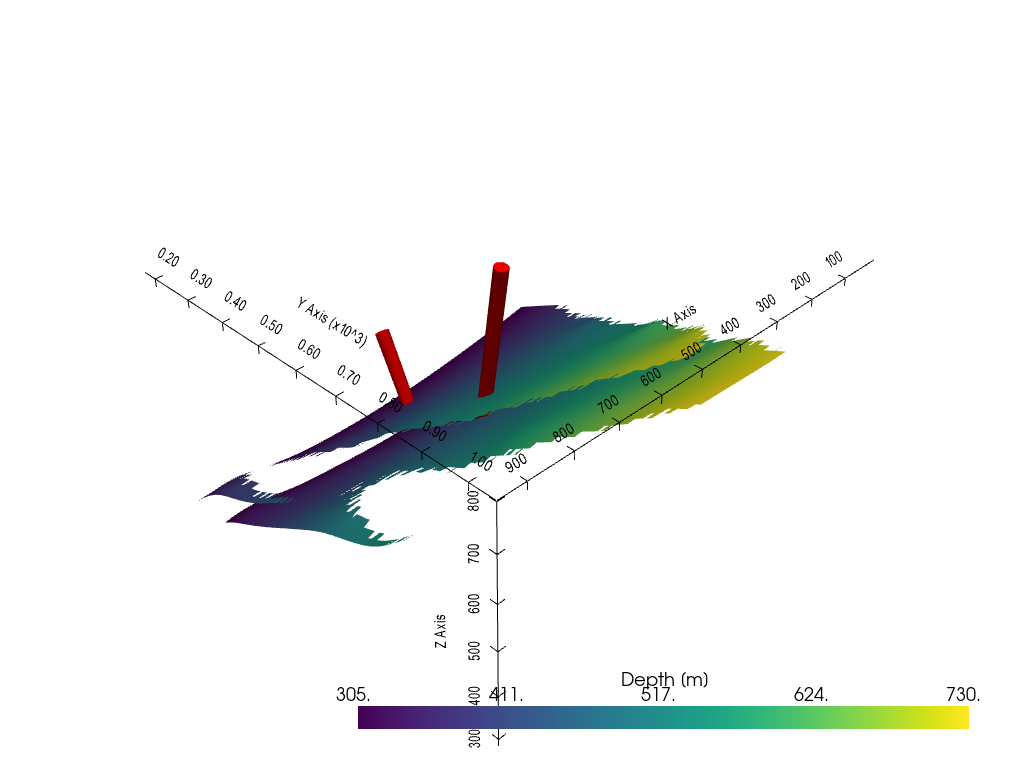

In [16]:
p = pv.Plotter(notebook=True)

p.add_mesh(mesh['Sand1'][0], scalars = 'Depth [m]')
p.add_mesh(mesh['Ton'][0], scalars = 'Depth [m]')
p.add_mesh(tube, color='red')
p.show_bounds()
p.show()

In [17]:
create_virtual_profile(names_surfaces=list(mesh.keys()),
                       surfaces=[mesh['Sand1'][0], mesh['Ton'][0]],
                       borehole=polyline)

,Surface,Z
0,Sand1,497.21
1,Ton,377.33
2,Sand1,357.01
3,Ton,313.96
